In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import itertools
import time
from tqdm import tqdm
import sympy as sp
x = sp.var('x')
from sympy import Symbol
from sympy.solvers import solve
import math
import matplotlib.pyplot as plt
import collections

import warnings
warnings.filterwarnings("ignore")

# Import our adaptive module:
from adaptive_MDP import Adaptive
from adaptive_MDP import Adaptive_New
from non_adaptive import NonAdaptive
import poly_utils

In [62]:
# Initial parameters
mu = 0.00015
gamma = 0.0027
beta = 0.0096
phi = 0.0044

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

### Adaptive parameters
b_s = 24 # Making the max utility attained at b_s/2 if a_s = 0
b_i = 20 # Making the max utility attained at b_i/2 if a_i = 0
b_z = 26 # Making the max utility attained at b_z/2 if a_z = 0
a_s = 0
a_i = 0
a_z = 0
nu = 0.1375
tau = 3
delta = 0.9986

# Immediate rewards:
def u_s(a):
    return (b_s*a - a**2)**nu - a_s
def u_i(a):
    return (b_i*a - a**2)**nu - a_i
def u_z(a):
    return (b_z*a - a**2)**nu - a_z

### Simulation parameters
t_max = 1500
steps = 100
x00 = [9999, 1, 0]

In [63]:
# Initialize adaptive instances
instance_adaptive_wutils = Adaptive_New(
    mu, gamma, beta, phi,
    tau, delta,
    u_s, u_i, u_z,
    t_max, steps, x00, max_contacts=30,
    logs=True, verbose=False)
start = time.time()
instance_adaptive_wutils.patch_uni_solutions()
end = time.time()
print(f"Running the adaptive algorithm took {(end - start)/60} minutes.")

Patching unit time solutions ...


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:21<00:00, 68.90it/s]

Running the adaptive algorithm took 0.3629471778869629 minutes.


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 3868.45it/s]


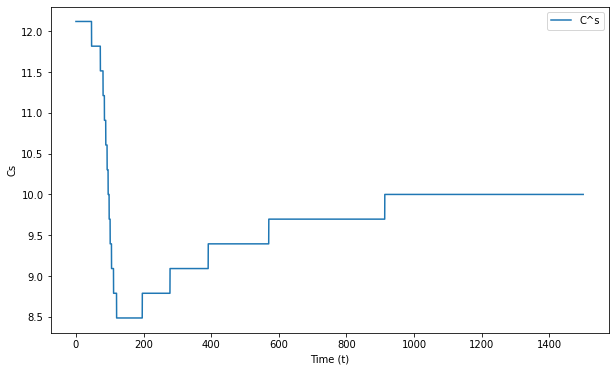

In [64]:
instance_adaptive_wutils.plot_C(instance_adaptive_wutils.cs_history)

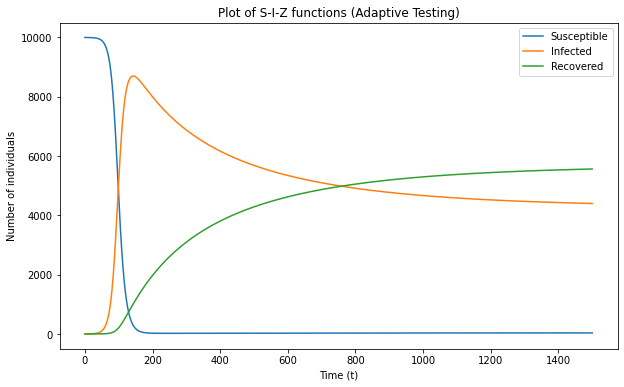

In [65]:
t = np.linspace(0, instance_adaptive_wutils.t_max, len(instance_adaptive_wutils.S))
instance_adaptive_wutils.plot_ode_solution(t = t, title = 'Adaptive Testing')

*We got a high epidemic peak because of the size of $\beta$, lower values of these parameter make the adaptive behavior disappear. I need to test with more significant examples and parameters*

##### Comparison with NON Adaptive models

In [66]:
start = time.time()
# To compare, we take the Cs obtained at the start (ex ante) and at the end (ex post)

instance_non_adaptive_ex_ante = NonAdaptive(
    mu, gamma, beta, phi, 
    instance_adaptive_wutils.cs_history[0],
    instance_adaptive_wutils.ci_history[0],
    instance_adaptive_wutils.cz_history[0], x00, t_max)

instance_non_adaptive_ex_post = NonAdaptive(
    mu, gamma, beta, phi,
    instance_adaptive_wutils.cs_history[-1],
    instance_adaptive_wutils.ci_history[-1],
    instance_adaptive_wutils.cz_history[-1], x00, t_max)

instance_non_adaptive_ex_ante.solve_odes_system()
instance_non_adaptive_ex_post.solve_odes_system()

end = time.time()
print(f"Running the NON adaptive algorithms took {end - start} seconds.")

100%|███████████████████████████████████████████████████████████████████████| 150001/150001 [00:04<00:00, 32980.95it/s]


Running the NON adaptive algorithms took 9.060590267181396 seconds.




Proportions and contacts.

Ex ante:
    - Cs: 12.121212121212121
    - Ci: 10.0
    - Cz: 13.030303030303031
    - kappa: 0.825
    - theta: 1.0750000000000002
    
Ex post:
    - Cs: 10.0
    - Ci: 10.0
    - Cz: 10.606060606060606
    - kappa: 1.0
    - theta: 1.0606060606060606

---- Final Points Attained ------------

Ex ante:  0.44013177051025776
Ex post:  0.43997584792294375
Adaptive: 0.4400541268697348

Theoretical Convergence Points:

Ex ante: [0.3979941986916157]
Ex post: [0.3957986825777138]

R0 Non Adaptive:

Ex ante: 3.3684210526315783
Ex post: 3.3684210526315783


Epidemic Maximum:

Ex ante:  8892.522395399079
Ex post:  8780.088111442708
Adaptive: 8697.65620326584

Time Epidemic Maximum is achieved:

Ex ante:  134.73
Ex post:  140.3
Adaptive: 144.15

------------------------------



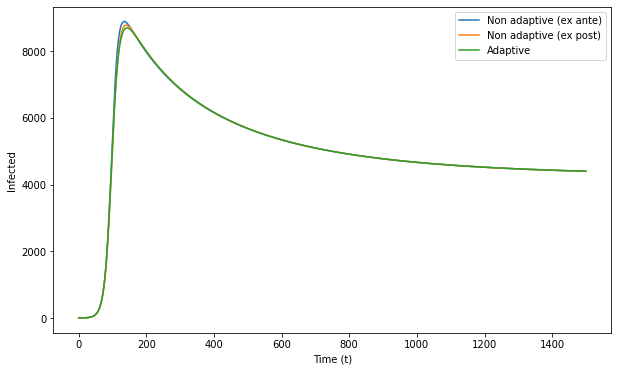

In [67]:
R0_ante = instance_non_adaptive_ex_ante.I[0]*beta/(gamma + mu)
R0_post = instance_non_adaptive_ex_post.I[0]*beta/(gamma + mu)

kappa_ante = instance_adaptive_wutils.ci_history[0]/instance_adaptive_wutils.cs_history[0]
theta_ante = instance_adaptive_wutils.cz_history[0]/instance_adaptive_wutils.cs_history[0]

kappa_post = instance_adaptive_wutils.ci_history[-1]/instance_adaptive_wutils.cs_history[-1]
theta_post = instance_adaptive_wutils.cz_history[-1]/instance_adaptive_wutils.cs_history[-1]

print(f"""

Proportions and contacts.

Ex ante:
    - Cs: {instance_adaptive_wutils.cs_history[0]}
    - Ci: {instance_adaptive_wutils.ci_history[0]}
    - Cz: {instance_adaptive_wutils.cz_history[0]}
    - kappa: {kappa_ante}
    - theta: {theta_ante}
    
Ex post:
    - Cs: {instance_adaptive_wutils.cs_history[-1]}
    - Ci: {instance_adaptive_wutils.ci_history[-1]}
    - Cz: {instance_adaptive_wutils.cz_history[-1]}
    - kappa: {kappa_post}
    - theta: {theta_post}

---- Final Points Attained ------------

Ex ante:  {instance_non_adaptive_ex_ante.I[-1]/sum(x00)}
Ex post:  {instance_non_adaptive_ex_post.I[-1]/sum(x00)}
Adaptive: {instance_adaptive_wutils.I[-1]/sum(x00)}

Theoretical Convergence Points:

Ex ante: {poly_utils.solve_polynomial(Rphi, Rmu, R0_ante, kappa_ante, theta_ante)}
Ex post: {poly_utils.solve_polynomial(Rphi, Rmu, R0_post, kappa_post, theta_post)}

R0 Non Adaptive:

Ex ante: {R0_ante}
Ex post: {R0_post}


Epidemic Maximum:

Ex ante:  {np.max(instance_non_adaptive_ex_ante.I)}
Ex post:  {np.max(instance_non_adaptive_ex_post.I)}
Adaptive: {np.max(instance_adaptive_wutils.I)}

Time Epidemic Maximum is achieved:

Ex ante:  {instance_non_adaptive_ex_ante.I.tolist().index(np.max(instance_non_adaptive_ex_ante.I))/steps}
Ex post:  {instance_non_adaptive_ex_post.I.tolist().index(np.max(instance_non_adaptive_ex_post.I))/steps}
Adaptive: {instance_adaptive_wutils.I.tolist().index(np.max(instance_adaptive_wutils.I))/steps}

------------------------------
""")

plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_ante.I)),
    instance_non_adaptive_ex_ante.I, label="Non adaptive (ex ante)")
plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_post.I)),
    instance_non_adaptive_ex_post.I, label="Non adaptive (ex post)")
plt.plot(
    np.linspace(0,t_max,len(instance_adaptive_wutils.I)),
    instance_adaptive_wutils.I, label="Adaptive")

# plt.axvline(x = 2400, color = 'b')

plt.xlabel("Time (t)")
plt.ylabel("Infected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

**Comments**
- As in the case with no reinfection we get a lower disease peak with adaptive behavior.
- The value of $\beta$ is very important, because it defines the magnitude of the transition probabilities for susceptibles. A very low $\beta$ results in no adaptive behavior at all. A higher $\beta$ allows for adaptive computations to rise, however it affects the disease simulation.
- TODO: Work on this to get a simulation with realistic disease progress and with adaptive computations.
------------------------------------------

*Closer:*

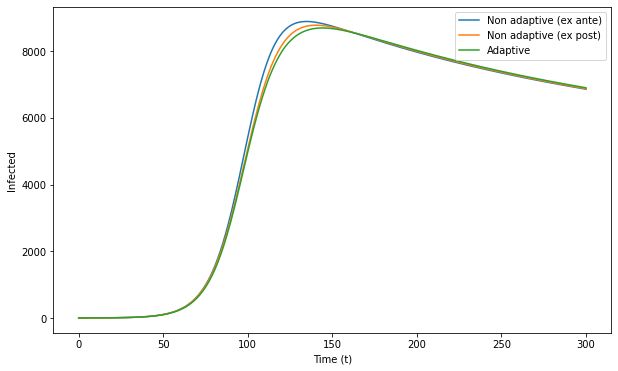

In [73]:
n=300
plt.plot(
    np.linspace(0, n, n*steps),
    instance_non_adaptive_ex_ante.I[0:n*steps], label="Non adaptive (ex ante)")
plt.plot(
    np.linspace(0, n, n*steps),
    instance_non_adaptive_ex_post.I[0:n*steps], label="Non adaptive (ex post)")
plt.plot(
    np.linspace(0, n, n*steps),
    instance_adaptive_wutils.I[0:n*steps], label="Adaptive")

# plt.axvline(x = 2400, color = 'b')

plt.xlabel("Time (t)")
plt.ylabel("Infected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

This is an extreme example. We need to modify it or find more suitable parameters.

In [68]:
# Old Code
# # Note: our start point is not [1,0,0]
# # Because the disease-free equilibrium is stable for models with demographics.

# Ci = 3
# Cs = Ci/kappa
# Cz = Cs*theta

# R0 = Ci*beta/(gamma+mu)
# roots = poly_utils.solve_polynomial(Rphi, Rmu, R0, kappa, theta)
# print(roots)

# # Initialize adaptive instances
# instance_adaptive = Adaptive(mu, gamma, beta, phi,
#                              b_s, b_i, b_z, a_s, a_i, a_z,
#                              nu, tau, delta, t_max, steps, x00)

# start = time.time()
# instance_adaptive.patch_uni_solutions()
# end = time.time()
# print(f"Running the adaptive algorithm took {(end - start)/60} minutes.")

# instance_adaptive.plot_C(instance_adaptive.Cs)